In [86]:
#hide
!pip install -Uqq fastbook
!pip install -U tensorflow-gpu==2.0.0 grpcio
import fastbook
fastbook.setup_book()


MessageError: ignored

In [ ]:
#hide
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Under the Hood: Training a Digit Classifier

## Pixels: The Foundations of Computer Vision

## Sidebar: Tenacity and Deep Learning

## End sidebar

In [ ]:
# The MNIST dataset was constructed from two datasets of the US National Institute of Standards and Technology (NIST). 
# The training set consists of handwritten digits from 250 different people, 50 percent high school students, 
# and 50 percent employees from the Census Bureau. Note that the test set contains handwritten digits from different people following the same split.
# The MNIST dataset is publicly available and consists of the following four parts:
#     Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, and 60,000 samples)
#     Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, and 60,000 labels)
#     Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, unzipped and 10,000 samples)
#     Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, and 10,000 labels)
# PyTorch provides two high-level features:
#     a) Tensor computation (like NumPy) with strong GPU acceleration
#     b) Deep Neural Networks built on a tape-based autodiff system
# PyTorch consists of 4 main packages:
#       torch: a general purpose array library similar to Numpy that can do computations on GPU when the tensor type is cast to (torch.cuda.TensorFloat)
#       torch.autograd: a package for building a computational graph and automatically obtaining gradients
#       torch.nn: a neural net library with common layers and cost functions
#       torch.optim: an optimization package with common optimization algorithms like SGD,Adam, etc
# PyTorch Tensors:
# In terms of programming, Tensors can simply be considered multidimensional arrays. 
# Tensors in PyTorch are similar to NumPy arrays, with the addition being that Tensors 
# can also be used on a GPU that supports CUDA. PyTorch supports various types of Tensors.
# The MNIST dataset contains 28 by 28 grayscale images of single handwritten digits between 0 and 9. 28*28 = 784
# The set consists of a total of 70,000 images, the training set having 60,000 and the test set has 10,000. 
# This means that there are 10 classes of digits, which includes the labels for the numbers 0 to 9.

In [87]:
# Download a sample of MNIST that contains images of just these digits
path = untar_data(URLs.MNIST_SAMPLE)

In [88]:
#hide
Path.BASE_PATH = path

In [89]:
# See what’s in this directory by using ls
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [90]:
# The MNIST dataset follows a common layout for machine learning datasets: separate folders for the training set and the validation 
# (and/or test) set. Let’s see what is inside the training set:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [91]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes
sevens
# It is full of image files

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

(#6265) [Path('train/7/10002.png'),Path('train/7/1001.png'),Path('train/7/10014.png'),Path('train/7/10019.png'),Path('train/7/10039.png'),Path('train/7/10046.png'),Path('train/7/10050.png'),Path('train/7/10063.png'),Path('train/7/10077.png'),Path('train/7/10086.png')...]

In [92]:
# There’s a folder of 3s, and a folder of 7s. 
# In machine learning parlance, we say that “3” and “7” are the labels (or targets) in this dataset. 
# Let us take a look in one of these folders (using sorted to ensure we all get the same order of files):
im3_path = threes[1]
im3 = Image.open(im3_path)
im3
im7_path = sevens[1]
im7 = Image.open(im7_path)
im7

In [93]:
# Here we are using the Image class from the Python Imaging Library (PIL), which is the most widely used Python package for opening,
# manipulating, and viewing images. Jupyter knows about PIL images, so it displays the image for us automatically.
# In a computer, everything is represented as a number. 
# To view the numbers that make up this image, we have to convert it to a NumPy array or a PyTorch tensor. 
# For instance, here’s what a section of the image looks like converted to a NumPy array:
# The 4:10 indicates that we requested the rows from index 4 (inclusive) to 10 (noninclusive) and the same for the columns. Numpy indexes
# from top to bottom and from left to right - so this section is located near the top left corner of the image 
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [323]:
tensor(im3)[0:28,0:28]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  29, 150, 195, 254, 255, 254, 176, 193, 150,  96,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,  48, 166, 224, 253, 253, 234, 196, 253, 253, 253, 253, 2

In [95]:
# We can slice the array to pick just the part with the top of the digit and then use Pandas data frame to color code
# the values using a gradient, which shows us clearly how the image is created from the pixel values
# The same display from the previous cell is now displayed below
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[0:10,0:10])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')


,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29
6,0,0,0,0,0,0,0,48,166,224
7,0,0,0,0,0,93,244,249,253,187
8,0,0,0,0,0,107,253,253,230,48
9,0,0,0,0,0,3,20,20,15,0


In [96]:
# We can slice the array to pick just the part with the top of the digit and then use Pandas data frame to color code
# the values using a gradient, which shows us clearly how the image is created from the pixel values
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

# You can see that the background white pixels are stored as the number 0, black is the number 255, 
# and shades of gray are between the two. The entire image contains 28 pixels across and 28 pixels down, 
# for a total of 784 pixels. (This is much smaller than an image that you would get from a phone camera, 
# which has millions of pixels, but is a convenient size for our initial learning and experiments. 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [97]:
# Another version of the same display with a different set of indices
im3_t_2 = tensor(im3)
df = pd.DataFrame(im3_t_2[4:55,4:55])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0,0,0,0,0,0,0


## First Try: Pixel Similarity

In [98]:
# You can see that the background white pixels are stored as the number 0, black is the number 255, and shades of gray are between the two. 
# The entire image contains 28 pixels across and 28 pixels down, for a total of 784 pixels. 
# (This is much smaller than an image that you would get from a phone camera, which has millions of pixels, 
# but is a convenient size for our initial learning and experiments.                                                                                                                                                                                                                                   We will build up to bigger, full-color images soon.)
# So, now you’ve seen what an image looks like to a computer, let’s recall our goal: 
# We need to create a model that can recognize 3s and 7s. 
# How might you go about getting a computer to do that? 
# This is now an exercise of thinking about features since the features of two dissimilar objects are going to have a different structure
# What kind of features might the program need to understand and evaluate? 
# How would it identify those features? How would it combine those features?
# You could start thinking about creating a vector of all the pixels for a 3 vs a 7
# We could compute an average pixel value for every pixel of the 3s and do the same for the 7s. This would give us an ideal point 
# measure of 3 vs 7 and could provide a baseline. We could then measure the average of an incoming 3 data point and then compare it 
# to the baseline 3 as well as 7 and see how far away the average for the candidate data point are from the ideal and then 
# probabilistically assign it to either 3 or 7 depending on high the probability measure are. This where tensors come in. 
# We can create a tensor containing all of our 3s stacked together using python list comprehension
# Review list comprehensions in python
# A list comprehension looks like this: new_list = [f(o) for o in a_list if o>0]. 
# This will return every element of a_list that is greater than 0, after passing it to the function f. 
# There are three parts here: the collection you are iterating over (a_list), 
# an optional filter (if o>0) or if then condition, and something to do to each element (f(o)). 
# It’s not only shorter to write, but also way faster than the alternative ways of creating the same list with a loop.


In [99]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

In [ ]:
show_image(three_tensors[1]);

In [100]:
# For every pixel position, we want to compute the average over all the images of the intensity of that pixel. 
# To do this, we first combine all the images in this list into a single three-dimensional tensor. 
# The most common way to describe such a tensor is to call it a rank-3 tensor. 
# We often need to stack up individual tensors in a collection into a single tensor. 
# PyTorch has a function called stack that we can use for this purpose. 
# Since these images are floats, the pixel values are expected to be between 0 and 1 and we will divide by 255.
# Why 255 - to convert RGB pixel values which are in the range of (0,255) to (0.0, 1.0). 
# Grey scale images have 256 values - 8 bit for each channel and 2^8 = 256!
# Tensors - founded by Gregorio Ricci-Curbastro, Tullio Levi-Civita who popularised tensors in 1900 
# – continuing the earlier work of Bernhard Riemann and Elwin Bruno Christoffel 
# Tensors - origin of the word from the muscle that stretche or tightens
# Tensors are a generalization of matrices and vectors
# The most important attributes of a tensor is its shape which for the threes have 6131 images - each of size 28 * 28. 
# There is nothing specifically about this tensor that says that the first axis is the number of images, the second is the height, 
# and the third is the width—the semantics of a tensor are entirely up to us, and how we construct it. 
# As far as PyTorch is concerned, it is just a bunch of numbers in memory. 
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape
stacked_sevens.shape

torch.Size([6131, 28, 28])

torch.Size([6265, 28, 28])

In [101]:
# Scalars - is a single number
x = np.array(49)
print(x)
print('A scalar is of rank %d' %(x.ndim))

49
A scalar is of rank 0


In [102]:
# Vector - single dimension (1D) tensor which is also refered to as an array. 
# A vector is made up of a series of numbers has 1 axis and is of rank 1
x = np.array([1, 1, 2, 3, 5, 8])
print(x)
print('A vector is of rank %d' %(x.ndim))
 

[1 1 2 3 5 8]
A vector is of rank 1


In [103]:
# Matrix - A matrix is a tensor of rank 2, meaning that it has 2 axes. 
# A matrix is arranged as a grid of numbers (think rows and columns), and is technically a 2 dimension (2D) tensor
x = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
print(x)
print('A matrix is of rank %d' %(x.ndim))

[[1 2 3]
 [4 5 6]
 [7 8 9]]
A matrix is of rank 2


In [104]:
# Tensors - speaking of the generalization of the concept of a matrix to N >= 3 dimensions
x = np.array([[[1, 4, 7],
               [2, 5, 8],
               [3, 6, 9]],
              [[10, 40, 70],
               [20, 50, 80],
               [30, 60, 90]],
              [[100, 400, 700],
               [200, 500, 800],
               [300, 600, 900]]])
print(x)
print('This tensor is of rank %d' %(x.ndim))

[[[  1   4   7]
  [  2   5   8]
  [  3   6   9]]

 [[ 10  40  70]
  [ 20  50  80]
  [ 30  60  90]]

 [[100 400 700]
  [200 500 800]
  [300 600 900]]]
This tensor is of rank 3


In [105]:
# The length of a tensor’s shape is its rank. It is important to commit to memory and practice these bits of tensor jargon: 
# Rank is the number of axes or dimensions in a tensor; shape is the size of each axis of a tensor. The rank of a tensor is different from 
# the rank of a matrix which is the number of independent dimensions of the matrix. A tensor has magnitude, direction and a plane and is a 
# generalization of matrices and vectors.
# The word dimension has multiple meanings and it is best to translate all statements into terms of rank, axis and length - which are unambigous 
len(stacked_threes.shape)

3

In [106]:
# Rank of stacked_threes
stacked_threes.ndim

3

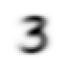

In [107]:
# Compute what an ideal 3 looks like. This will compute for every pixel position, the average of that pixel over all images. 
# The result will be one value for every pixel position, or a single image
# The image is blurry and wispy as it is an average
mean3 = stacked_threes.mean(0)
show_image(mean3);

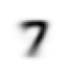

In [108]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

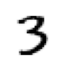

In [109]:
# Let us pick an arbitrary 3 and measure its distance from our "ideal digits"
a_3 = stacked_threes[1]
show_image(a_3);

In [110]:
# There are two broad ways to do this 
# 1. The mean of the absolute value of differences, with negative values replaced with positive values - mean absolute difference - L1 norm
# 2. The root mean square (RMSE) or the mean of the square of differences and then take the square root of the sum  - L2 norm
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [111]:
# Compute the distance of the arbitrary 3 from the 7 digit mean
# In both cases, the distance between our 3 and the “ideal” 3 is less than the distance to the ideal 7, 
# so our simple model will give the right prediction in this case.
# (tensor(0.1114), tensor(0.2021)) < (tensor(0.1586), tensor(0.3021))
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [112]:
# We use the loss function provided by PyTorch which is inside torch.nn.functional, which the PyTorch team recommends importing as F
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### NumPy Arrays and PyTorch Tensors

In [113]:
# Numpy is the most widely used library for scientific and numeric programming in Python. 
# It provides similar functionality and a similar API to that provided by PyTorch; 
# however, it does not support using the GPU or calculating gradients, which are both critical for deep learning. 
# Therefore, we will generally use PyTorch tensors instead of NumPy arrays, where possible.
# A PyTorch tensor is nearly the same thing as a NumPy array except it can live on the GPU and can run much faster
# GPUs are specifically designed to accelerate computer workloads.
# a PyTorch tensors also cannot be jagged. It is always a regularly shaped multidimensional rectangular structure.
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [114]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [115]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [116]:
# You can select a row - like lists in Python tensors are 0-indexed - so 1 refers to the second row / column
tns[1]

tensor([4, 5, 6])

In [117]:
# Indexing by column
tns[:,1]

tensor([2, 5])

In [118]:
# Use the Python slice syntax ([start:end]) - start with the second row / column
tns[1,1:3]

tensor([5, 6])

In [119]:
# Use standard operators
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [120]:
# Tensors have a type
tns.type()

'torch.LongTensor'

In [121]:
# Will automatically change that type as needed; for example, from int to float:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

## Computing Metrics Using Broadcasting

In [122]:
# Is the baseline measure any good. For that we need to define metrics
# The mse or rmse are not understandable to most people - and we need to define accuracy as the metric for classification models
# We want to calculate our metric over a validation set. This is so that we do not inadvertently overfit—that is, train a model 
# to work well only on our training data. A validation dataset has already been created.
# Create tensors for our 3s and 7s from that directory. 
# These are the tensors we will use to calculate a metric measuring the quality of our first effort / try model, 
# which measures distance from an ideal image:
# These computations are from the validation dataset.
# Check the shapes as you go. There are two tensors here - one representing the 3s validation data set of 1010 images of size 28*28
# and the other representing the 7s validation set of 1028 images of size 28*28
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [123]:
#Define a simple function that calculates the mean absolute error and apply it on the arbitrary chosen 3 - same value as before
def mnist_distance(a,b): 
  return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [124]:
# We need to calculate the distance to the ideal 3 for every image in teh validation set. Normally we would use a for loop 
# over all the simgle image tensors and that are stacked within our validation set tensor valid_3_tens, which has a shape of [1010,28,28] representing 1,010 images
# PyTorch, when it tries to perform a simple subtraction operation between two tensors of different ranks, will use broadcasting: 
# it will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank. 
# Broadcasting is an important capability that makes tensor code much easier to write.
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape
valid_3_dist.ndim

(tensor([0.1366, 0.1413, 0.1489,  ..., 0.1327, 0.1455, 0.1337]),
 torch.Size([1010]))

1

In [125]:
# Another example
tensor([1,2,3]) + tensor([1,1,1])

tensor([2, 3, 4])

In [126]:
# So in this case, PyTorch treats mean3, a rank-2 tensor representing a single image, 
# as if it were 1,010 copies of the same image, and then subtracts each of those copies from each 3 in our validation set.
# There are a couple of important points about how broadcasting is implemented, which make it valuable not just for expressivity 
# but also for performance:

# PyTorch does not actually copy mean3 1,010 times. It pretends it were a tensor of that shape, but does not allocate any additional memory
# It does the whole calculation in C (or, if you’re using a GPU, in CUDA, the equivalent of C on the GPU), 
# tens of thousands of times faster than pure Python (up to millions of times faster on a GPU!).
# This is true of all broadcasting and elementwise operations and functions done in PyTorch. 
# It is the most important technique for you to know to create efficient PyTorch code.
# There is in mnist_distance the abs function. 
# You might be able to guess now what this does when applied to a tensor. 
# It applies the method to each individual element in the tensor, and returns a tensor of the results 
# (that is, it applies the method elementwise). So in this case, we’ll get back 1,010 matrices of absolute values.
# Finally, our function calls mean((-1,-2)). 
# The tuple (-1,-2) represents a range of axes. In Python, -1 refers to the last element, and -2 refers to the second-to-last. 
# So in this case, this tells PyTorch that we want to take the mean ranging over the values indexed by the last two axes of the tensor. 
# The last two axes are the horizontal and vertical dimensions of an image. After taking the mean over the last two axes, 
# we are left with just the first tensor axis, which indexes over our images, which is why our final size was (1010). 
# In other words, for every image, we averaged the intensity of all the pixels in that image.
(valid_3_tens-mean3).shape

SyntaxError: ignored

In [127]:
# We can use mnist_distance to figure out whether an image is a 3 by using the following logic: 
# If the distance between the digit in question and the ideal 3 is less than the distance to the ideal 7, then it’s a 3. 
# This function will automatically do broadcasting and be applied elementwise, just like all PyTorch functions and operators: 
def is_3(x): 
  return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [128]:
# Test it out in our example case - Converting a Boolean response to a float - we get 1.0 for True and 0.0 for False
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [129]:
# Test it out on the full validation set of 3s - 1010 images
is_3(valid_3_tens)

tensor([ True,  True, False,  ...,  True,  True,  True])

In [130]:
# Now we can calculate the accuracy for each of the 3s and 7s, by taking the average of that function for all 3s and 
# its inverse for all 7s: Our classification accuracy is very good!!!
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent (SGD)

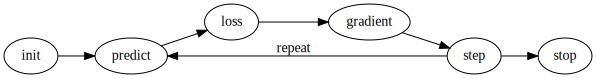

In [324]:
# As we discussed, this is the key to allowing us to have a model that can get better and better—that can learn. 
# But our pixel similarity approach does not really do this. 
# We do not have any kind of weight assignment, or any way of improving based on testing the effectiveness of a weight assignment. 
# In other words, we cannot really improve our pixel similarity approach by modifying a set of parameters. 
# To take advantage of the power of deep learning, we will first have to represent our task in the way that alters the weight assignment
# so as to maximize perfromance.
# Instead of trying to find the similarity between an image and an “ideal image,” 
# we could instead look at each individual pixel and come up with a set of weights for each, 
# such that the highest weights are associated with those pixels most likely to be black for a particular category. 
# For instance, pixels toward the bottom right are not very likely to be activated for a 7, 
# so they should have a low weight for a 7, but they are likely to be activated for an 3, 
# so they should have a high weight for an 3. 
# This can be represented as a function and set of weight values for each possible category—for instance, 
# the probability of being the number 3:

def pr_three(x, w): 
  return (x*w).sum()

gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')


In [131]:
# To be more specific, here are the steps required to turn this function into a machine learning classifier:
# Initialize the weights. - We initialize the parameters to random values. 
     # This may sound surprising. There are certainly other choices we could make, such as initializing them to the percentage of 
     # times that pixel is activated for that category—but since we already know that we have a routine to improve these weights, 
     # it turns out that just starting with random weights works perfectly well.
# For each image, use these weights to predict whether it appears to be a 3 or a 7.
# Based on these predictions, calculate how good the model is (its loss).
# Calculate the gradient, which measures for each weight how changing that weight would change the loss.
     # We need to test the effectiveness of any current weight assignment in terms of actual performance. 
     # We need a function that will return a number that is small if the performance of the model is good 
     # (the standard approach is to treat a small loss as good and a large loss as bad, although this is just a convention).
# Step (that is, change) all the weights based on that calculation.
     # A simple way to figure out whether a weight should be increased a bit or decreased a bit would be just to try it: 
     # increase the weight by a small amount, and see if the loss goes up or down. 
     # Once you find the correct direction, you could then change that amount by a bit more, 
     # or a bit less, until you find an amount that works well. 
     # However, this is slow! As we will see, the magic of calculus allows us to directly figure out - using second derivatives
     # in which direction, and by roughly how much, to change each weight, without having to try all these small changes. 
     # The way to do this is by calculating gradients. 
     # This is just a performance optimization; we would get exactly the same results by using the slower manual process as well.
# Go back to step 2 and repeat the process.
     # Once we have decided how many epochs to train the model for we apply that decision. 
     # For our digit classifier, we would keep training until the accuracy of the model started getting worse, or we ran out of time.
# Iterate until you decide to stop the training process (for instance, because the model is good enough or you do not want to wait any longer).


In [132]:
def f(x): return x**2

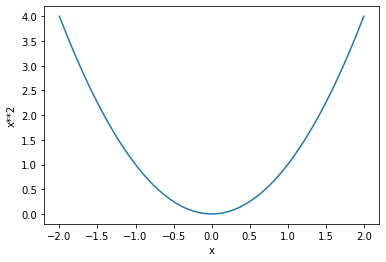

In [133]:
plot_function(f, 'x', 'x**2')

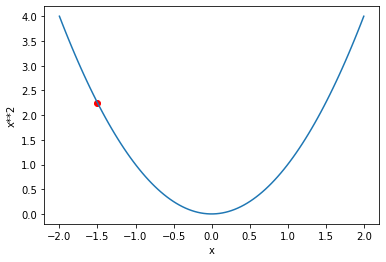

In [134]:
# The sequence of steps we described earlier starts by picking a random value for a parameter, and calculating the value of the loss:
# Now we look to see what would happen if we increased or decreased our parameter by a little bit—the adjustment. 
# This is simply the slope at a particular point:
# We can change our weight by a little in the direction of the slope, calculate our loss and adjustment again, 
# and repeat this a few times. Eventually, we will get to the lowest point on our curve:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

### Calculating Gradients

In [155]:
# Calculating gradients. We use calculus as a performance optimization; it allows us to more quickly calculate whether 
# our loss will go up or down when we adjust our parameters up or down. 
# In other words, the gradients will tell us how much we have to change each weight to make our model better.
# You may remember from your high school calculus class that the derivative of a function tells you how much a change 
# in its parameters will change its result. 
# The key point about a derivative is this: for any function, such as the quadratic function we saw in the previous section, 
# we can calculate its derivative. The derivative is another function. 
# It calculates the change, rather than the value. For instance, the derivative of the quadratic function at the value 3 
# tells us how rapidly the function changes at the value 3. More specifically, you may recall that gradient is defined as rise/run; 
# It tells us the change in the value of the function, divided by the change in the value of the parameter. 
# When we know how our function will change, we know what we need to do to make it smaller. 
# This is the key to machine learning: having a way to change the parameters of a function to make it smaller. 
# Calculus provides us with a computational shortcut, the derivative, which lets us directly calculate the gradients of our functions.
# One important thing to be aware of is that our function has lots of weights that we need to adjust, 
# so when we calculate the derivative, we will not get back one number, but
# multiple numbers — a gradient for every weight. But there is nothing mathematically tricky here; 
# you can calculate the derivative with respect to one weight and treat all the other ones as constant, 
# and then repeat that for each other weight. This is how all of the gradients are calculated, for every weight.
# PyTorch is able to automatically compute the derivative of nearly any function! 
# First, let’s pick a tensor value at which we want gradients using the requires_grad_ function

xt = tensor(3.).requires_grad_()
xt_7 = tensor(7.).requires_grad_()


In [163]:
# Now we calculate our function with that value. 
# Notice how PyTorch prints not just the value calculated, but also a note that it has a gradient function it will be 
# using to calculate our gradients when needed:
yt = f(xt)
yt
','
yt_7 = f(xt_7)
yt_7

tensor(125., grad_fn=<SumBackward0>)

','

tensor(49., grad_fn=<SumBackward0>)

In [153]:
# The “backward” here refers to backpropagation, which is the name given to the process of calculating the derivative of each layer. 
# This is called the backward pass of the network, as opposed to the forward pass, which is where the activations are calculated.
yt.backward()

In [154]:
# We can now view the gradients by checking the grad attribute of our tensor:
# If you remember your high school calculus rules, the derivative of x**2 is 2*x, and we have x=3, 
# so the gradients should be 2*3=6, which is what PyTorch calculated for us!
xt.grad

tensor(6.)

In [157]:
# Repeat the preceding steps, but with a vector argument for our function:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [158]:
# Add sum to our function so it can take a vector (i.e., a rank-1 tensor) and return a scalar (i.e., a rank-0 tensor):
def f(x): 
  return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [164]:
# Our gradients are 2*xt, as we’d expect!
# The gradients tell us only the slope of our function; they do not tell us exactly how far to adjust the parameters. 
# But they do give us some idea of how far: if the slope is very large, that may suggest that we have more adjustments to do, 
# whereas if the slope is very small, that may suggest that we are close to the optimal value.
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

In [166]:
# Deciding how to change our parameters based on the values of the gradients is an important part of the deep learning process. 
# Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the learning rate (LR). 
# The learning rate is often a number between 0.001 and 0.1, although it could be anything. 
# Once you’ve picked a learning rate, you can adjust your parameters using this simple function:


### Stepping With a Learning Rate

### An End-to-End SGD Example

In [280]:
# We have seen how to use gradients to minimize our loss. Now it is time to look at an SGD example and see how finding a minimum 
# can be used to train a model to fit data better.
# Let us start with a simple, synthetic example model. Imagine you were measuring the speed of a roller coaster 
# as it went over the top of a hump. It would start fast, and then get slower as it went up the hill; 
# it would be slowest at the top, and it would then speed up again as it went downhill. 
# You want to build a model of how the speed changes over time. 
# If you were measuring the speed manually every second for 20 seconds, it might look something like this:
time = torch.arange(0,30).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29.])

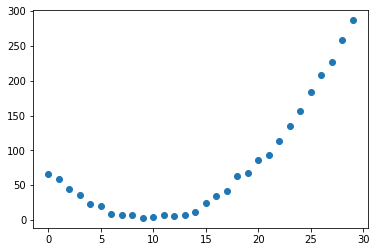

In [281]:
speed = torch.randn(30)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [282]:
# We have added a bit of random noise, since measuring things manually is not precise.
# This means it is not that easy to answer the question: what was the roller coaster’s speed? 
# Using SGD, we can try to find a function that matches our observations. 
# We cannot consider every possible function, so let us use a guess that it will be quadratic; 
# i.e., a function of the form a*(time**2)+(b*time)+c.
# We want to distinguish clearly between the function’s input (the time when we are measuring the coaster’s speed) 
# and its parameters (the values that define which quadratic we’re trying). 
# So let us collect the parameters in one argument and thus separate the input, t, and the parameters, params, 
# in the function’s signature:def f(t, params):
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [283]:
# In other words, we have restricted the problem of finding the best imaginable function that fits the data to finding the best 
# quadratic function. This greatly simplifies the problem, since every quadratic function is fully defined by the 
# three parameters a, b, and c. Thus, to find the best quadratic function, we need to find only the best values for a, b, and c.

# If we can solve this problem for the three parameters of a quadratic function, we will be able to apply the same approach for other, 
# more complex functions with more parameters—such as a neural net. Let us find the parameters for f first, and then we will come back 
# and do the same thing for the MNIST dataset with a neural net.

# We need to define first what we mean by “best.” We define this precisely by choosing a loss function, 
# which will return a value based on a prediction and a target, where lower values of the function correspond to “better” predictions. 
# For continuous data, it’s common to use mean squared error:def mse(preds, targets): return ((preds-targets)**2).mean().sqrt()

#### Step 1: Initialize the parameters

In [284]:
# First, we initialize the parameters to random values and tell PyTorch that we want to track their gradients using requires_grad_:

params = torch.randn(3).requires_grad_() 

In [285]:
#hide
orig_params = params.clone() 

#### Step 2: Calculate the predictions

In [286]:
preds = f(time, params)

In [287]:
# Let us create a little function to see how close our predictions are to our targets, and take a look:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100) 

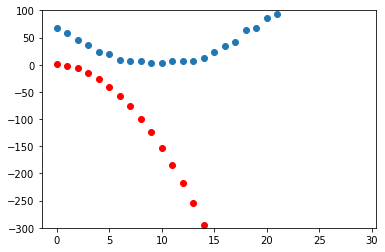

In [288]:
# This does not look good. Our random parameters suggest that the roller coaster will end up going backward, since we have negative speeds!
show_preds(preds)

#### Step 3: Calculate the loss

In [289]:
# We calculate the loss as follows:
loss = mse(preds, speed)
loss

TensorBase(454777.5625, grad_fn=<AliasBackward0>)

#### Step 4: Calculate the gradients

In [290]:
# Our goal is now to improve the loss function shown below. To do that, we will need to know the gradients.
# The next step is to calculate the gradients, or an approximation of how the parameters need to change:

loss.backward()
params.grad

tensor([-519768.5625,  -21897.7402,    -995.5009])

In [291]:
# Multiplying with a learning parameter - 1/100000
params.grad * 1e-5

tensor([-5.1977, -0.2190, -0.0100])

In [292]:
params

tensor([-1.4220, -1.1712,  1.1226], requires_grad=True)

#### Step 5: Step the weights. 

In [293]:
# Update the parameters based on the gradients we calculated
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [294]:
# Has the loss improved?
preds = f(time,params)
mse(preds, speed)

TensorBase(1782750.8750, grad_fn=<AliasBackward0>)

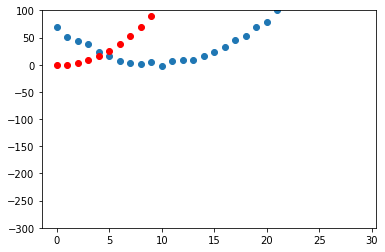

In [186]:
show_preds(preds)

In [295]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

In [296]:
# Iterate and looping over the process, we can determien the improvement if any
for i in range(10): apply_step(params)

1782750.875


tensor([1.1326e+00, 3.9559e+00, 1.4331e+01, 3.2256e+01, 5.7734e+01, 9.0762e+01, 1.3134e+02, 1.7947e+02, 2.3516e+02, 2.9839e+02, 3.6917e+02, 4.4751e+02, 5.3340e+02, 6.2684e+02, 7.2783e+02, 8.3637e+02,
        9.5246e+02, 1.0761e+03, 1.2073e+03, 1.3460e+03, 1.4923e+03, 1.6462e+03, 1.8076e+03, 1.9765e+03, 2.1530e+03, 2.3371e+03, 2.5287e+03, 2.7279e+03, 2.9346e+03, 3.1488e+03],
       grad_fn=<AddBackward0>)

6996082.5


tensor([ 1.1128e+00, -6.8001e+00, -2.7758e+01, -6.1762e+01, -1.0881e+02, -1.6891e+02, -2.4204e+02, -3.2823e+02, -4.2746e+02, -5.3974e+02, -6.6506e+02, -8.0342e+02, -9.5483e+02, -1.1193e+03,
        -1.2968e+03, -1.4873e+03, -1.6909e+03, -1.9076e+03, -2.1373e+03, -2.3800e+03, -2.6358e+03, -2.9046e+03, -3.1864e+03, -3.4814e+03, -3.7893e+03, -4.1103e+03, -4.4444e+03, -4.7914e+03,
        -5.1516e+03, -5.5248e+03], grad_fn=<AddBackward0>)

27462478.0


tensor([1.1519e+00, 1.4507e+01, 5.5627e+01, 1.2451e+02, 2.2116e+02, 3.4557e+02, 4.9775e+02, 6.7769e+02, 8.8540e+02, 1.1209e+03, 1.3841e+03, 1.6751e+03, 1.9939e+03, 2.3404e+03, 2.7147e+03, 3.1167e+03,
        3.5466e+03, 4.0041e+03, 4.4895e+03, 5.0026e+03, 5.5435e+03, 6.1121e+03, 6.7085e+03, 7.3327e+03, 7.9846e+03, 8.6643e+03, 9.3718e+03, 1.0107e+04, 1.0870e+04, 1.1661e+04],
       grad_fn=<AddBackward0>)

107809112.0


tensor([ 1.0744e+00, -2.7714e+01, -1.0960e+02, -2.4457e+02, -4.3264e+02, -6.7381e+02, -9.6807e+02, -1.3154e+03, -1.7159e+03, -2.1694e+03, -2.6760e+03, -3.2358e+03, -3.8486e+03, -4.5145e+03,
        -5.2335e+03, -6.0056e+03, -6.8308e+03, -7.7091e+03, -8.6405e+03, -9.6250e+03, -1.0663e+04, -1.1753e+04, -1.2897e+04, -1.4094e+04, -1.5344e+04, -1.6647e+04, -1.8003e+04, -1.9412e+04,
        -2.0874e+04, -2.2390e+04], grad_fn=<AddBackward0>)

423232288.0


tensor([1.2280e+00, 5.5938e+01, 2.1776e+02, 4.8671e+02, 8.6276e+02, 1.3459e+03, 1.9362e+03, 2.6336e+03, 3.4381e+03, 4.3498e+03, 5.3685e+03, 6.4944e+03, 7.7274e+03, 9.0675e+03, 1.0515e+04, 1.2069e+04,
        1.3730e+04, 1.5499e+04, 1.7375e+04, 1.9357e+04, 2.1447e+04, 2.3644e+04, 2.5949e+04, 2.8360e+04, 3.0878e+04, 3.3504e+04, 3.6236e+04, 3.9076e+04, 4.2023e+04, 4.5077e+04],
       grad_fn=<AddBackward0>)

1661515520.0


tensor([ 9.2367e-01, -1.0981e+02, -4.3086e+02, -9.6223e+02, -1.7039e+03, -2.6559e+03, -3.8182e+03, -5.1909e+03, -6.7738e+03, -8.5671e+03, -1.0571e+04, -1.2785e+04, -1.5209e+04, -1.7843e+04,
        -2.0688e+04, -2.3743e+04, -2.7009e+04, -3.0485e+04, -3.4171e+04, -3.8067e+04, -4.2174e+04, -4.6491e+04, -5.1018e+04, -5.5756e+04, -6.0704e+04, -6.5862e+04, -7.1231e+04, -7.6810e+04,
        -8.2599e+04, -8.8599e+04], grad_fn=<AddBackward0>)

6522742272.0


tensor([1.5266e+00, 2.1859e+02, 8.5429e+02, 1.9086e+03, 3.3816e+03, 5.2732e+03, 7.5834e+03, 1.0312e+04, 1.3460e+04, 1.7026e+04, 2.1011e+04, 2.5414e+04, 3.0236e+04, 3.5477e+04, 4.1136e+04, 4.7214e+04,
        5.3710e+04, 6.0625e+04, 6.7959e+04, 7.5712e+04, 8.3883e+04, 9.2472e+04, 1.0148e+05, 1.1091e+05, 1.2075e+05, 1.3102e+05, 1.4170e+05, 1.5280e+05, 1.6432e+05, 1.7626e+05],
       grad_fn=<AddBackward0>)

25606846464.0


tensor([ 3.3201e-01, -4.3210e+02, -1.6921e+03, -3.7796e+03, -6.6946e+03, -1.0437e+04, -1.5007e+04, -2.0405e+04, -2.6630e+04, -3.3683e+04, -4.1563e+04, -5.0271e+04, -5.9806e+04, -7.0169e+04,
        -8.1360e+04, -9.3378e+04, -1.0622e+05, -1.1990e+05, -1.3440e+05, -1.4972e+05, -1.6588e+05, -1.8286e+05, -2.0067e+05, -2.1931e+05, -2.3878e+05, -2.5907e+05, -2.8019e+05, -3.0214e+05,
        -3.2492e+05, -3.4852e+05], grad_fn=<AddBackward0>)

100526882816.0


tensor([2.6988e+00, 8.5716e+02, 3.3532e+03, 7.4908e+03, 1.3270e+04, 2.0691e+04, 2.9753e+04, 4.0457e+04, 5.2802e+04, 6.6789e+04, 8.2418e+04, 9.9688e+04, 1.1860e+05, 1.3915e+05, 1.6135e+05, 1.8518e+05,
        2.1066e+05, 2.3778e+05, 2.6654e+05, 2.9695e+05, 3.2899e+05, 3.6268e+05, 3.9800e+05, 4.3497e+05, 4.7358e+05, 5.1383e+05, 5.5573e+05, 5.9926e+05, 6.4444e+05, 6.9126e+05],
       grad_fn=<AddBackward0>)

394646716416.0


tensor([-1.9907e+00, -1.6973e+03, -6.6433e+03, -1.4840e+04, -2.6287e+04, -4.0985e+04, -5.8933e+04, -8.0132e+04, -1.0458e+05, -1.3228e+05, -1.6323e+05, -1.9743e+05, -2.3489e+05, -2.7559e+05,
        -3.1954e+05, -3.6675e+05, -4.1720e+05, -4.7091e+05, -5.2786e+05, -5.8807e+05, -6.5153e+05, -7.1823e+05, -7.8819e+05, -8.6140e+05, -9.3786e+05, -1.0176e+06, -1.1005e+06, -1.1867e+06,
        -1.2762e+06, -1.3689e+06], grad_fn=<AddBackward0>)

In [189]:
#hide
params = orig_params.detach().requires_grad_()

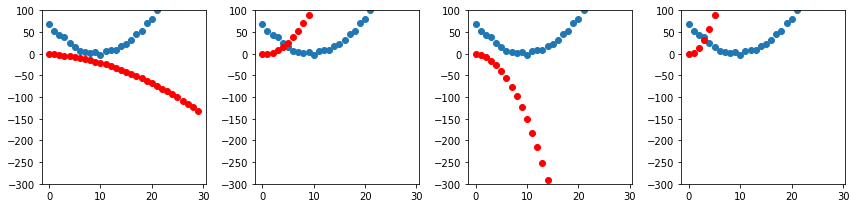

In [190]:
# The loss is going down, just as we hoped! But looking only at these loss numbers disguises the fact that each iteration 
# represents an entirely different quadratic function being tried, on the way to finding the best possible quadratic function. 
# We can see this process visually if, instead of printing out the loss function, we plot the function at every step. 
# Then we can see how the shape is approaching the best possible quadratic function for our data:
# We just decided to stop after 10 epochs arbitrarily. 
# In practice, we would watch the training and validation losses and our metrics to decide when to stop, as we’ve discussed.
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

### Summarizing Gradient Descent

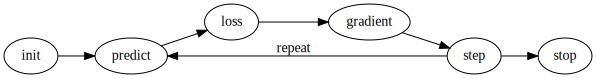

In [191]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

## The MNIST Loss Function

In [192]:
# We already have our xs—that is, our independent variables, the images themselves. 
# We will concatenate them all into a single tensor, and also change them from a list of matrices (a rank-3 tensor)
# to a list of vectors (a rank-2 tensor). We can do this using view, which is a PyTorch method that changes the shape 
# of a tensor without changing its contents. -1 is a special parameter to view that means 
# “make this axis as big as necessary to fit all the data”:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [193]:
# We need a label for each image. We will use 1 for 3s and 0 for 7s:

train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [194]:
# A Dataset in PyTorch is required to return a tuple of (x,y) when indexed. 
# Python provides a zip function that, when combined with list, provides a simple way to get this functionality:

dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [195]:

valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [196]:
# Now we need an (initially random) weight for every pixel (this is the initialize step in our seven-step process):
def init_params(size, std=1.0): 
  return (torch.randn(size)*std).requires_grad_()

In [197]:
# The function weights*pixels won’t be flexible enough—it is always equal to 0 when the pixels are equal to 0 
# (i.e., its intercept is 0). You might remember from high school math that the formula for a line is y = w*x+b y = Ax = b
# we still need the b. We’ll initialize it to a random number too:
weights = init_params((28*28,1))

In [201]:
# In neural networks, the w in the equation y=w*x+b is called the weights, and the b is called the bias. 
# In statistical modeling alpha or A in the equation y = A*x+b is called the intercept, and the b is called the parameter
# Together, the weights and bias make up the parameters.

bias = init_params(1)

In [202]:
# We can now calculate a prediction for one image:
(train_x[0]*weights.T).sum() + bias

tensor([16.4771], grad_fn=<AddBackward0>)

In [203]:
# We use matrix multiplication here
# The first element is the same as we calculated before, as we’d expect. This equation, batch @ weights + bias, 
# is one of the two fundamental equations of any neural network (the other one is the activation function, which we’ll see in a moment).
# Let us check our accuracy. To decide if an output represents a 3 or a 7, we can just check whether it is greater than 0, 
# so our accuracy for each item can be calculated (using broadcasting, so no loops!) as follows:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ 1.6477e+01],
        [ 1.3574e+01],
        [ 8.4074e+00],
        ...,
        [-3.5249e-03],
        [ 3.7751e+00],
        [ 3.0716e+00]], grad_fn=<AddBackward0>)

In [204]:

corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [False],
        [False]])

In [205]:
# Now let us see what the change in accuracy is for a small change in one of the weights:
corrects.float().mean().item()

0.5282348990440369

In [ ]:
weights[0] *= 1.0001

In [206]:

preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.5282348990440369

In [207]:
# As we have seen, we need gradients in order to improve our model using SGD, and in order to calculate gradients we need a loss function 
# that represents how good our model is. That is because the gradients are a measure of how that loss function changes with small tweaks 
# to the weights.

# So, we need to choose a loss function. The obvious approach would be to use accuracy, which is our metric, as our loss function as well. 
# In this case, we would calculate our prediction for each image, collect these values to calculate an overall accuracy, 
# and then calculate the gradients of each weight with respect to that overall accuracy.

# Unfortunately, we have a significant technical problem here. The gradient of a function is its slope, or its steepness, 
# which can be defined as rise over run—that is, how much the value of the function goes up or down, divided by how much we changed the input. 
# We can write this mathematically as:

# (y_new – y_old) / (x_new – x_old)
# This gives a good approximation of the gradient when x_new is very similar to x_old, meaning that their difference is very small. 
# But accuracy changes at all only when a prediction changes from a 3 to a 7, or vice versa. 
# The problem is that a small change in weights from x_old to x_new isn’t likely to cause any prediction to change, so (y_new – y_old) 
# will almost always be 0. In other words, the gradient is 0 almost everywhere.

# A very small change in the value of a weight will often not change the accuracy at all.
# This means it is not useful to use accuracy as a loss function—if we do, most of the time our gradients will be 0, 
# and the model will not be able to learn from that number.

# Instead, we need a loss function that, when our weights result in slightly better predictions, 
# gives us a slightly better loss. So what does a “slightly better prediction” look like, exactly? 
# Well, in this case, it means that if the correct answer is a 3, the score is a little higher, or if the correct answer is a 7, 
# the score is a little lower.

# Let’s write such a function now. What form does it take?

# The loss function receives not the images themselves, but the predictions from the model. 
# So let’s make one argument, prds, of values between 0 and 1, where each value is the prediction that an image is a 3. 
# It is a vector (i.e., a rank-1 tensor) indexed over the images.

# The purpose of the loss function is to measure the difference between predicted values and the true values—that is, 
# the targets (aka labels). Let’s therefore make another argument, trgts, with values of 0 or 1 that tells whether an image actually is a 3 or not. It is also a vector (i.e., another rank-1 tensor) indexed over the images.

# For instance, suppose we had three images that we knew were a 3, a 7, and a 3. 
# And suppose our model predicted with high confidence (0.9) that the first was a 3, with slight confidence (0.4) 
# that the second was a 7, and with fair confidence (0.2), but incorrectly, that the last was a 7. 
# This would mean our loss function would receive these values as its inputs:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [297]:
# We’re using a new function, torch.where(a,b,c). 
# This is the same as running the list comprehension [b[i] if a[i] else c[i] for i in range(len(a))], 
# except it works on tensors, at C/CUDA speed. In plain English, this function will measure how distant each prediction is from 1 
# if it should be 1, and how distant it is from 0 if it should be 0, and then it will take the mean of all those distances.

def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [209]:

torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [210]:
# You can see that this function returns a lower number when predictions are more accurate, 
# when accurate predictions are more confident (higher absolute values), and when inaccurate predictions are less confident. 
# In PyTorch, we always assume that a lower value of a loss function is better. 
# Since we need a scalar for the final loss, mnist_loss takes the mean of the previous tensor:
mnist_loss(prds,trgts)

tensor(0.4333)

In [211]:
# For instance, if we change our prediction for the one “false” target from 0.2 to 0.8, the loss will go down, 
# indicating that this is a better prediction:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

### Sigmoid

In [212]:
# One problem with mnist_loss as currently defined is that it assumes that predictions are always between 0 and 1. 
# We need to ensure, then, that this is actually the case! As it happens, there is a function that does exactly that—let’s take a look.
# The sigmoid function always outputs a number between 0 and 1. It’s defined as follows:
# Also called the logistic function

def sigmoid(x): return 1/(1+torch.exp(-x))

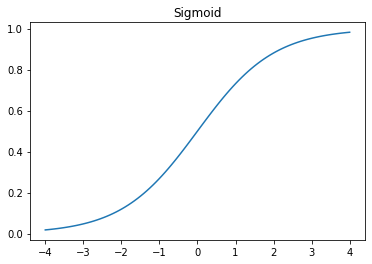

In [298]:
# As you can see, it takes any input value, positive or negative, and smooshes it into an output value between 0 and 1. 
# It is also a smooth curve that only goes up, which makes it easier for SGD to find meaningful gradients.
# Let’s update mnist_loss to first apply sigmoid to the inputs:

plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [213]:
# Now we can be confident our loss function will work, even if the predictions are not between 0 and 1. 
# All that is required is that a higher prediction corresponds to higher confidence.

# Having defined a loss function, now is a good moment to recapitulate why we did this. 
# After all, we already had a metric, which was overall accuracy. So why did we define a loss?

# The key difference is that the metric is to drive human understanding and the loss is to drive automated learning. 
# To drive automated learning, the loss must be a function that has a meaningful derivative. It can’t have big flat sections and large jumps, but instead must be reasonably smooth. This is why we designed a loss function that would respond to small changes in confidence level. This requirement means that sometimes it does not really reflect exactly what we are trying to achieve, but is rather a compromise between our real goal and a function that can be optimized using its gradient. The loss function is calculated for each item in our dataset, and then at the end of an epoch, the loss values are all averaged and the overall mean is reported for the epoch.

# Metrics, on the other hand, are the numbers that we care about. 
# These are the values that are printed at the end of each epoch that tell us how our model is doing. 
# It is important that we learn to focus on these metrics, rather than the loss, when judging the performance of a model.

def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### SGD and Mini-Batches

In [214]:
# Now that we have a loss function suitable for driving SGD, we can consider some of the details involved in the next 
# phase of the learning process, which is to change or update the weights based on the gradients. This is called an optimization step.

# To take an optimization step, we need to calculate the loss over one or more data items. How many should we use? 
# We could calculate it for the whole dataset and take the average, or we could calculate it for a single data item. 
# But neither of these is ideal. Calculating it for the whole dataset would take a long time. 
# Calculating it for a single item would not use much information, so it would result in an imprecise and unstable gradient. 
# You’d be going to the trouble of updating the weights, but taking into account only how that would improve 
# the model’s performance on that single item.

# So instead we compromise: we calculate the average loss for a few data items at a time. 
# This is called a mini-batch. The number of data items in the mini-batch is called the batch size. 
# A larger batch size means that you will get a more accurate and stable estimate of your dataset’s gradients 
# from the loss function, but it will take longer, and you will process fewer mini-batches per epoch. 
# Choosing a good batch size is one of the decisions you need to make as a deep learning practitioner to train 
# your model quickly and accurately. 
# Another good reason for using mini-batches rather than calculating the gradient on individual data items is that, 
# in practice, we nearly always do our training on an accelerator such as a GPU. 
# These accelerators perform well only if they have lots of work to do at a time, 
# so it’s helpful if we can give them lots of data items to work on. 
# Using mini-batches is one of the best ways to do this. 
# However, if you give them too much data to work on at once, they run out of memory—making GPUs happy is also tricky!
# we get better generalization if we can vary things during training. 
# One simple and effective thing we can vary is what data items we put in each mini-batch. 
# Rather than simply enumerating our dataset in order for every epoch, 
# instead what we normally do is randomly shuffle it on every epoch, before we create mini-batches. 
# PyTorch and fastai provide a class that will do the shuffling and mini-batch collation for you, called DataLoader.

# A DataLoader can take any Python collection and turn it into an iterator over many batches, like so:

coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [215]:
# For training a model, we don’t just want any Python collection, but a collection containing independent and dependent variables 
# (the inputs and targets of the model). 
# A collection that contains tuples of independent and dependent variables is known in PyTorch as a Dataset. 
# Here’s an example of an extremely simple Dataset:

ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [299]:
# When we pass a Dataset to a DataLoader we will get back many batches that are themselves tuples of 
# tensors representing batches of independent and dependent variables:

dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([ 3, 16, 17,  8,  7,  2]), ('d', 'q', 'r', 'i', 'h', 'c')),
 (tensor([10, 22,  4, 14, 25, 15]), ('k', 'w', 'e', 'o', 'z', 'p')),
 (tensor([ 1, 12, 19,  5,  9, 11]), ('b', 'm', 't', 'f', 'j', 'l')),
 (tensor([ 0, 23, 21, 13, 18, 20]), ('a', 'x', 'v', 'n', 's', 'u')),
 (tensor([ 6, 24]), ('g', 'y'))]

## Putting It All Together

In [321]:
# In code, our process will be implemented something like this for each epoch:
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr


NameError: ignored

In [313]:
weights = init_params((28*28,1))
bias = init_params(1)

In [314]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [316]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [315]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [317]:
preds = linear1(batch)
preds

tensor([[-1.0036],
        [-4.9414],
        [-6.4834],
        [ 6.0567]], grad_fn=<AddBackward0>)

In [318]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(2.5929, grad_fn=<MeanBackward0>)

In [319]:
 # Calculate the gradients
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.1511), tensor([-1.]))

In [320]:
# Put it in a function
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [308]:
# test it
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.3022), tensor([-2.]))

In [309]:

calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.4534), tensor([-3.]))

In [310]:
weights.grad.zero_()
bias.grad.zero_();

In [227]:
# Our only remaining step is to update the weights and biases based on the gradient and learning rate. 
# When we do so, we have to tell PyTorch not to take the gradient of this step too—otherwise, 
# things will get confusing when we try to compute the derivative at the next batch! 
# If we assign to the data attribute of a tensor, PyTorch will not take the gradient of that step. 
# Here’s our basic training loop for an epoch:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [229]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [False],
        [False]])

In [230]:
# That gives us this function to calculate our validation accuracy:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [231]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

In [232]:
# And then put the batches together:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [233]:
# That’s our starting point. Let’s train for one epoch and see if the accuracy improves:

validate_epoch(linear1)

0.4883

In [234]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6718

In [235]:
# Looking good! We’re already about at the same accuracy as our “pixel similarity” approach, 
# and we’ve created a general-purpose foundation we can build on. 
# Our next step will be to create an object that will handle the SGD step for us. In PyTorch, it’s called an optimizer.
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8637 0.9125 0.9359 0.9476 0.953 0.9574 0.9613 0.9633 0.9647 0.9667 0.9672 0.9687 0.9696 0.9701 0.9711 0.9716 0.9721 0.9726 0.9726 0.973 

### Creating an Optimizer

In [236]:
# Because this is such a general foundation, PyTorch provides some useful classes to make it easier to implement. 
# The first thing we can do is replace our linear1 function with PyTorch’s nn.Linear module. 
# A module is an object of a class that inherits from the PyTorch nn.Module class. 
# Objects of this class behave identically to standard Python functions, in that you can call them using parentheses, 
# and they will return the activations of a model.

# nn.Linear does the same thing as our init_params and linear together. 
# It contains both the weights and biases in a single class. 
# Here’s how we replicate our model from the previous section:

linear_model = nn.Linear(28*28,1)

In [237]:
# Every PyTorch module knows what parameters it has that can be trained; they are available through the parameters method:


w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [238]:
# We can use this information to create an optimizer:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [239]:
# We can create our optimizer by passing in the model’s parameters:

opt = BasicOptim(linear_model.parameters(), lr)

In [240]:
# Our training loop can now be simplified:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [241]:
# Our validation function doesn’t need to change at all:

validate_epoch(linear_model)

0.4527

In [242]:
# Let’s put our little training loop in a function, to make things simpler:

def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [243]:
train_model(linear_model, 20)

0.4932 0.8208 0.8433 0.9126 0.9331 0.9473 0.9561 0.9634 0.9653 0.9683 0.9702 0.9722 0.9746 0.9751 0.9761 0.9771 0.9775 0.9775 0.9785 0.979 

In [244]:
# fastai provides the SGD class that, by default, does the same thing as our BasicOptim:

linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.5691 0.6821 0.8789 0.9209 0.9404 0.9521 0.9595 0.9644 0.9658 0.9683 0.9702 0.9722 0.9736 0.9746 0.9761 0.9771 0.9775 0.9775 0.978 

In [245]:
# fastai also provides Learner.fit, which we can use instead of train_model. 
# To create a Learner, we first need to create a DataLoaders, by passing in our training and validation DataLoaders:

dls = DataLoaders(dl, valid_dl)

In [246]:
# To create a Learner without using an application (such as cnn_learner), 
# we need to pass in all the elements that we’ve created in this chapter: the DataLoaders, 
# the model, the optimization function (which will be passed the parameters), the loss function, and optionally any metrics to print:


import requests
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [247]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637478,0.503210,0.495584,00:00
1,0.447612,0.272222,0.742395,00:00
2,0.168053,0.160805,0.855741,00:00
3,0.075343,0.099934,0.915604,00:00
4,0.041036,0.074606,0.934740,00:00
5,0.027523,0.060473,0.948970,00:00
6,0.021905,0.051516,0.957311,00:00
7,0.019370,0.045491,0.963199,00:00
8,0.018062,0.041231,0.966143,00:00
9,0.017264,0.038078,0.968597,00:00


## Adding a Nonlinearity

In [248]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [249]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

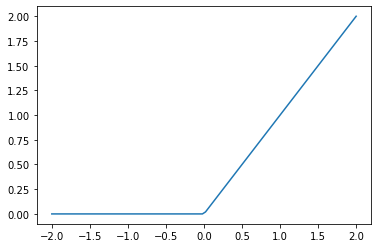

In [250]:
plot_function(F.relu)

In [251]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [252]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [253]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.284436,0.410935,0.505397,00:00
1,0.136610,0.214424,0.819921,00:00
2,0.076950,0.109428,0.920510,00:00
3,0.051449,0.075154,0.943081,00:00
4,0.039482,0.059288,0.958783,00:00
5,0.033271,0.050318,0.965162,00:00
6,0.029644,0.044625,0.966634,00:00
7,0.027256,0.040701,0.967615,00:00
8,0.025523,0.037828,0.969087,00:00
9,0.024177,0.035624,0.969578,00:00


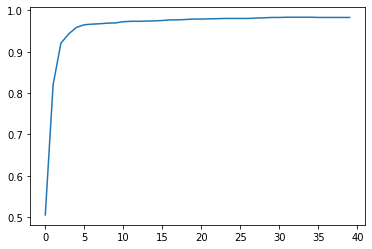

In [254]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [255]:
learn.recorder.values[-1][2]

0.982826292514801

### Going Deeper

In [256]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.109901,0.005950,0.998037,03:23
